# TensorBoard Metrics Analysis for Swing Option RL Runs
This notebook loads scalar metrics from a specified run directory inside `runs/` (e.g. `MonthlySwing1`) and plots all available TensorBoard scalar tags.

## Features
- Auto-discovery of event files in `runs/<RUN_NAME>`
- Extraction of all scalar tags
- Unified pandas DataFrame (one row per (step, tag))
- Individual plots & combined facet-style grid
- Optional exponential moving average smoothing

Set `RUN_NAME` below to analyze a different run.

In [2]:
import os, glob, math, json, itertools
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

RUN_NAME = 'MonthlySwing1'  # change this to target another run folder
# Robust project root detection: ascend until we find 'runs'
cur = Path.cwd()
project_root = None
for parent in [cur] + list(cur.parents):
    if (parent / 'runs').exists():
        project_root = parent
        break
if project_root is None:
    raise FileNotFoundError('Could not locate a runs directory in current or parent paths.')
RUNS_DIR = project_root / 'runs'
RUN_PATH = RUNS_DIR / RUN_NAME
print('Project root:', project_root)
print('Runs dir:', RUNS_DIR)
assert RUN_PATH.exists(), f'Run path not found: {RUN_PATH}'
event_files = sorted(RUN_PATH.glob('events.out.tfevents.*'))
assert event_files, f'No TensorBoard event files found in {RUN_PATH}'
print(f'Using event files:')
for f in event_files: print('  -', f.name)

Project root: /Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM
Runs dir: /Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/runs
Using event files:
  - events.out.tfevents.1755693941.Alexanders-MacBook-Air-5.local.4506.0


In [3]:
def load_scalars(event_paths):
    records = []
    for ep in event_paths:
        ea = event_accumulator.EventAccumulator(str(ep), size_guidance={'scalars': 0})
        ea.Reload()
        for tag in ea.Tags().get('scalars', []):
            for ev in ea.Scalars(tag):
                records.append({'tag': tag, 'step': ev.step, 'wall_time': ev.wall_time, 'value': ev.value})
    df = pd.DataFrame(records)
    if df.empty:
        raise ValueError('No scalar data extracted.')
    df.sort_values(['tag','step'], inplace=True)
    return df

scalars_df = load_scalars(event_files)
print('Extracted tags:', sorted(scalars_df.tag.unique()))
scalars_df.head()

Extracted tags: ['Actor_loss', 'Average100', 'Avg_Exercise_Count', 'Avg_Total_Exercised', 'Collection_Progress', 'Critic_loss', 'Episode_Return', 'Learning_Rate/Actor', 'Learning_Rate/Critic', 'PER/priority_entropy', 'PER/priority_max', 'PER/priority_mean', 'PER/priority_min', 'PER/priority_std', 'Path_Length', 'Paths_Per_Second', 'Policy/Action_variance_mean', 'Policy/Actions_at_lower_pct', 'Policy/Actions_at_upper_pct', 'Price_Std', 'Stability/Target_drift', 'Steps_Per_Second', 'Swing_Option_Price', 'TD_Error/p50', 'TD_Error/p90', 'TD_Error/p99', 'Total_Steps']


,tag,step,wall_time,value
120170,Actor_loss,10005,1.755694e+09,0.009998
120171,Actor_loss,10008,1.755694e+09,-0.009526
120172,Actor_loss,10011,1.755694e+09,-0.033402
120173,Actor_loss,10014,1.755694e+09,-0.049972
120174,Actor_loss,10017,1.755694e+09,-0.064068


In [4]:
def add_ema(df, span=50):
    # Adds EMA per tag
    df = df.copy()
    df['ema'] = (
        df.groupby('tag')['value']
          .transform(lambda s: s.ewm(span=span, adjust=False).mean())
    )
    return df

EMA_SPAN = 100  # adjust or set to None to disable
if EMA_SPAN:
    scalars_df = add_ema(scalars_df, span=EMA_SPAN)
scalars_df.head()

,tag,step,wall_time,value,ema
120170,Actor_loss,10005,1.755694e+09,0.009998,0.009998
120171,Actor_loss,10008,1.755694e+09,-0.009526,0.009612
120172,Actor_loss,10011,1.755694e+09,-0.033402,0.008760
120173,Actor_loss,10014,1.755694e+09,-0.049972,0.007597
120174,Actor_loss,10017,1.755694e+09,-0.064068,0.006178


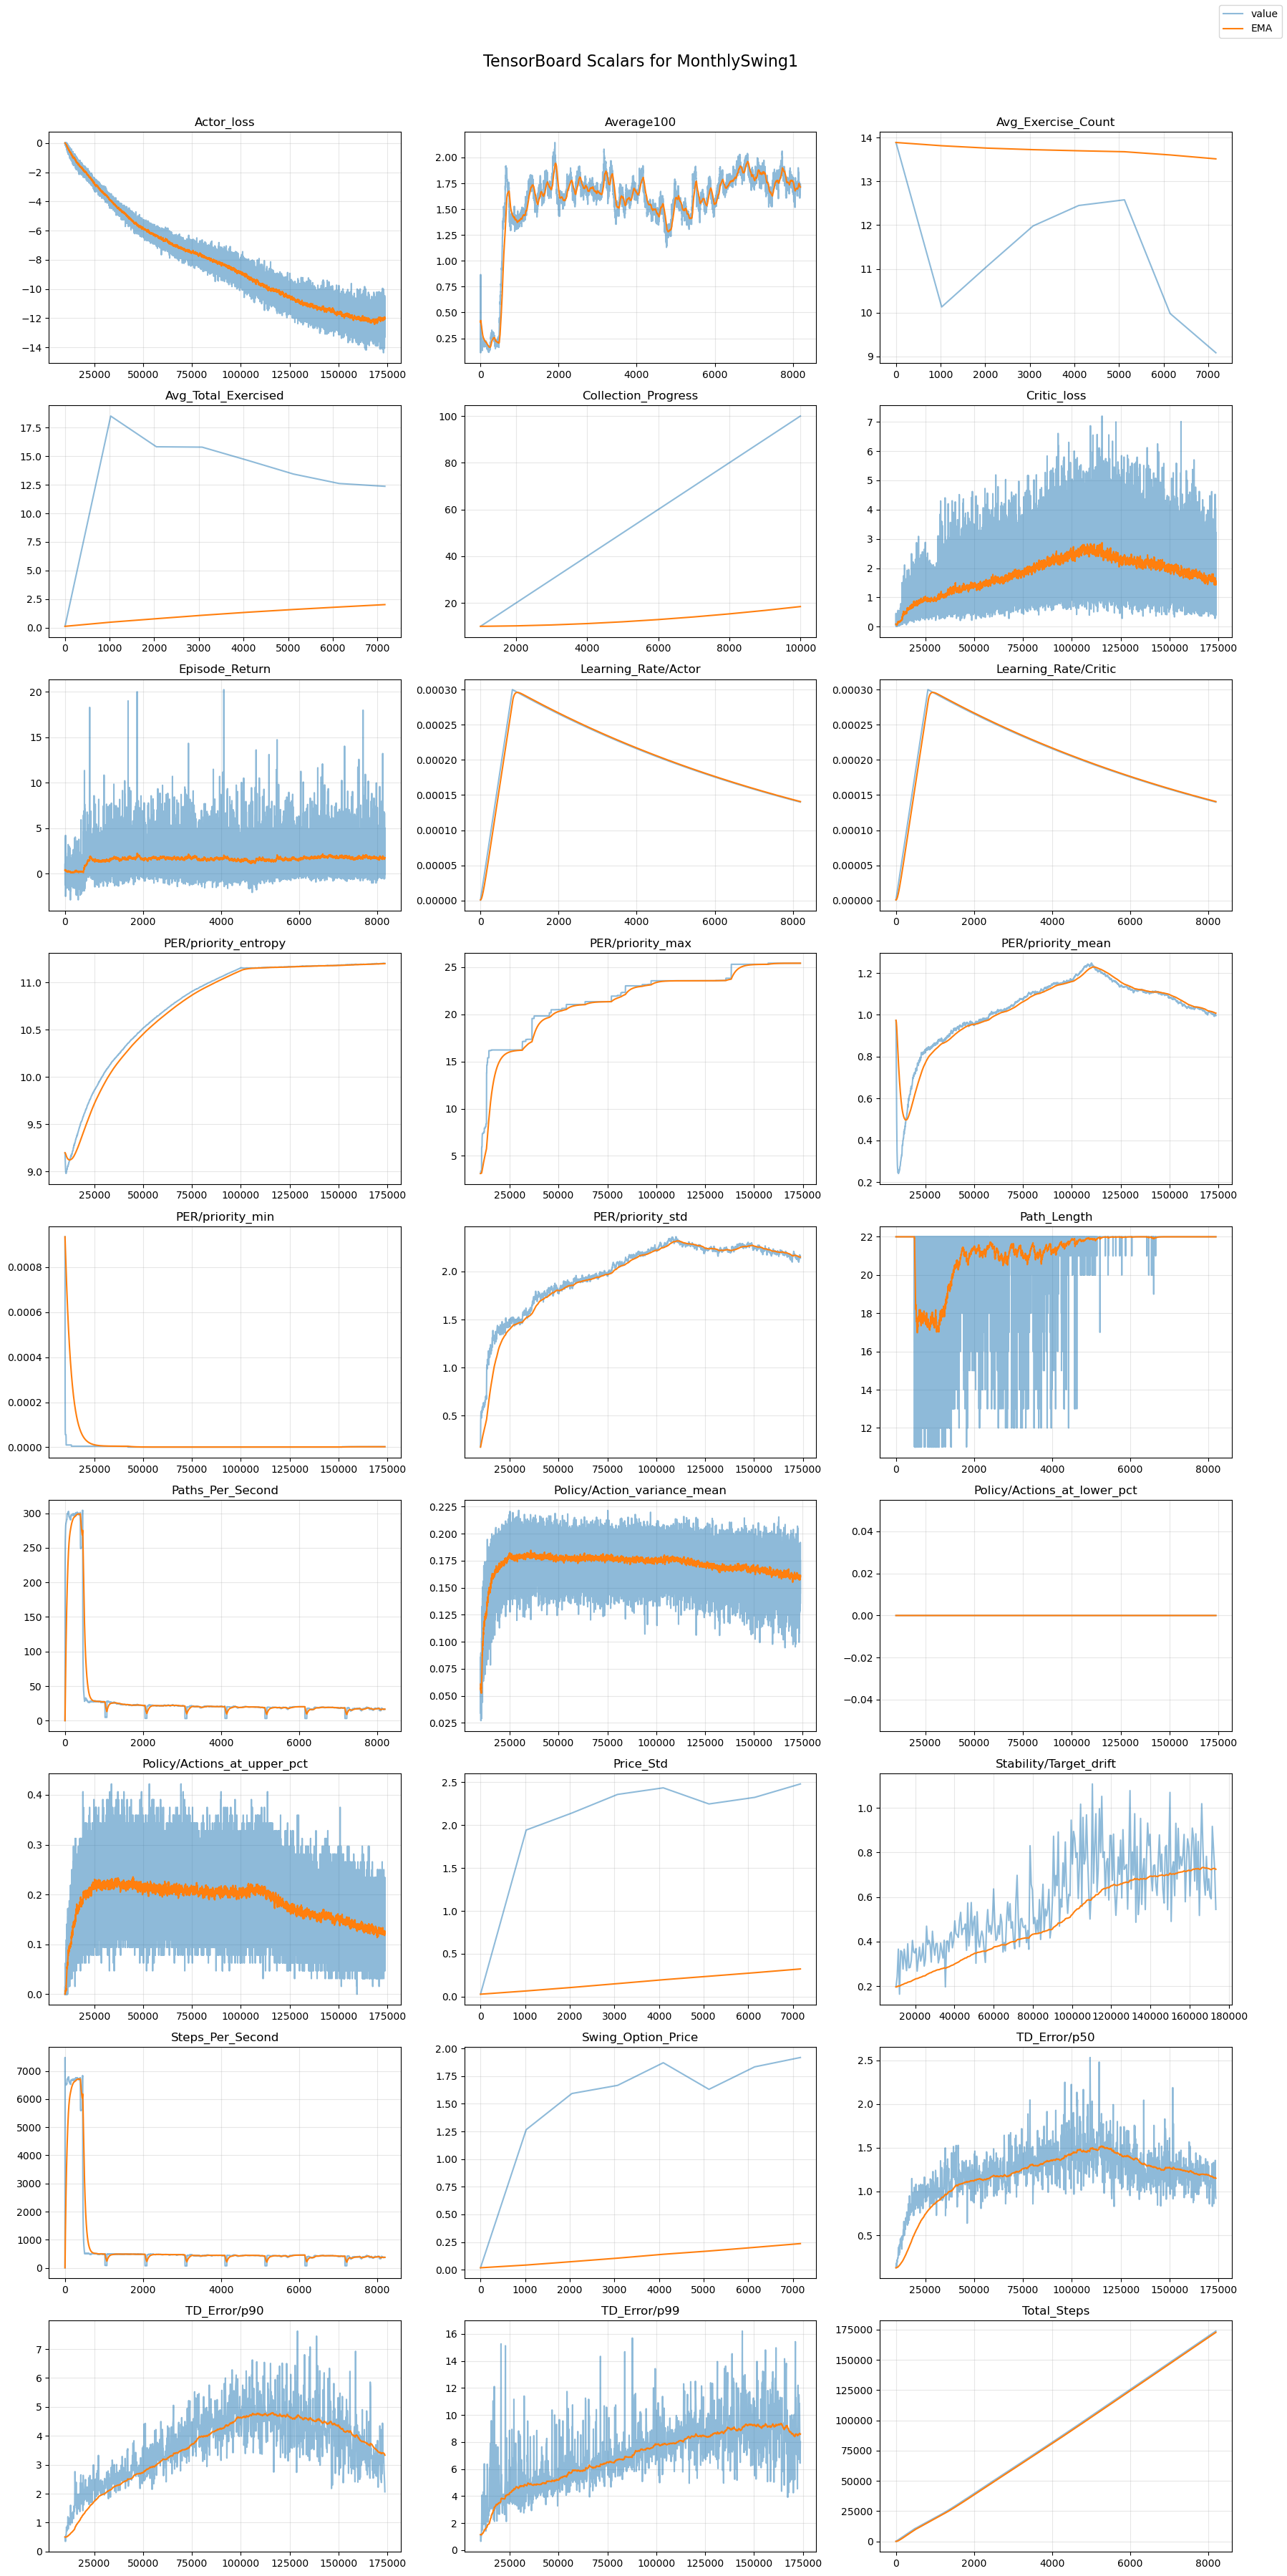

In [5]:
def plot_all(df, use_ema=True, max_cols=3, figsize=(18, 4)):
    tags = sorted(df.tag.unique())
    n = len(tags)
    cols = min(max_cols, n)
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1]*rows), squeeze=False)
    for i, tag in enumerate(tags):
        r, c = divmod(i, cols)
        ax = axes[r][c]
        d = df[df.tag == tag]
        ax.plot(d.step, d.value, label='value', alpha=0.5)
        if use_ema and 'ema' in d:
            ax.plot(d.step, d.ema, label=f'EMA', linewidth=1.5)
        ax.set_title(tag)
        ax.grid(True, alpha=0.3)
    # Remove empty subplots
    for j in range(i+1, rows*cols):
        r, c = divmod(j, cols)
        axes[r][c].axis('off')
    handles, labels = axes[0][0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc='upper right')
    fig.suptitle(f'TensorBoard Scalars for {RUN_NAME}', fontsize=16)
    plt.tight_layout(rect=[0,0,0.98,0.97])
    return fig

plot_all(scalars_df, use_ema=True);

In [6]:
# Quick single-tag focus utility
def plot_tag(df, tag, use_ema=True):
    d = df[df.tag == tag]
    if d.empty:
        raise ValueError(f'Tag not found: {tag}')
    plt.figure(figsize=(8,4))
    plt.plot(d.step, d.value, label='value', alpha=0.6)
    if use_ema and 'ema' in d:
        plt.plot(d.step, d.ema, label='EMA')
    plt.title(f'{tag} ({RUN_NAME})')
    plt.xlabel('step')
    plt.grid(alpha=0.3)
    plt.legend()

# Example (uncomment and set a real tag):
# plot_tag(scalars_df, 'Critic_loss')

In [8]:
# Export metrics & hyperparameters for LLM-assisted hyperparameter tuning
from datetime import datetime
import math

export_root = project_root / 'HyperparameterTuning' / RUN_NAME
export_root.mkdir(parents=True, exist_ok=True)
print('Export directory:', export_root)

# (a) Copy / load hyperparameter json from runs
hp_json_src = project_root / 'runs' / f'{RUN_NAME}.json'
if hp_json_src.exists():
    hp_json_dst = export_root / f'{RUN_NAME}_hyperparams.json'
    import shutil, json
    shutil.copy2(hp_json_src, hp_json_dst)
    print('Copied hyperparameters JSON ->', hp_json_dst)
    with open(hp_json_src) as f_in:
        hyperparams = json.load(f_in)
else:
    hyperparams = {}
    print('WARNING: Hyperparameter JSON not found:', hp_json_src)

# (b) Decide on CSV splitting strategy (keep single unless file gets huge)
MAX_ROWS_PER_CSV = 250_000  # adjustable threshold
rows = len(scalars_df)
num_parts = math.ceil(rows / MAX_ROWS_PER_CSV)

base_cols = ['tag','step','value']
if 'ema' in scalars_df.columns:
    base_cols.append('ema')

if num_parts == 1:
    out_path = export_root / f'{RUN_NAME}_1.csv'
    scalars_df[base_cols].to_csv(out_path, index=False)
    print(f'Wrote {rows} rows to', out_path)
else:
    for i in range(num_parts):
        chunk = scalars_df.iloc[i*MAX_ROWS_PER_CSV:(i+1)*MAX_ROWS_PER_CSV]
        out_path = export_root / f'{RUN_NAME}_{i+1}.csv'
        chunk[base_cols].to_csv(out_path, index=False)
        print(f'Wrote chunk {i+1}/{num_parts} with {len(chunk)} rows ->', out_path)

# (c) Summary statistics per tag for quick LLM ingestion
summary = (scalars_df
           .groupby('tag')['value']
           .agg(['count','min','max','mean','std'])
           .reset_index())
summary_out = export_root / f'{RUN_NAME}_summary.csv'
summary.to_csv(summary_out, index=False)
print('Summary stats written ->', summary_out)

# (d) Optional correlation matrix between tags (pivot first)
try:
    pivot = scalars_df.pivot_table(index='step', columns='tag', values='value')
    corr = pivot.corr().round(4)
    corr_out = export_root / f'{RUN_NAME}_correlations.csv'
    corr.to_csv(corr_out)
    print('Correlation matrix written ->', corr_out)
except Exception as e:
    print('Correlation matrix skipped:', e)

print('Export complete.')

Export directory: /Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/HyperparameterTuning/MonthlySwing1
Copied hyperparameters JSON -> /Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/HyperparameterTuning/MonthlySwing1/MonthlySwing1_hyperparams.json
Wrote chunk 1/2 with 250000 rows -> /Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/HyperparameterTuning/MonthlySwing1/MonthlySwing1_1.csv
Wrote chunk 2/2 with 105737 rows -> /Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/HyperparameterTuning/MonthlySwing1/MonthlySwing1_2.csv
Summary stats written -> /Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/HyperparameterTuning/MonthlySwing1/MonthlySwing1_summary.csv
Correlation matrix written -> /Users/alexanderithakis/Documents/GitHub/D4PG-QR-FRM/HyperparameterTuning/MonthlySwing1/MonthlySwing1_correlations.csv
Export complete.
